<a href="https://colab.research.google.com/github/avkornaev/Fast_AI_course/blob/main/XRayFullImagesAnalysisWithoutSwap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
#!git clone 'https://github.com/avkornaev/Fast_AI_course'
#!wget <ENTER URL> Download dataset from the web with

Connect to Google disk.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import libraries. Connect to Google disk.

In [3]:
import fastbook
#fastbook.setup_book() #an alternative to drive.mount with gdrive path instead of drive path 
import numpy as np
import pandas as pd
from fastbook import *
from fastai.data.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *

Path.


In [4]:
dataPath = Path('/content/drive/MyDrive/Covid_detection_Kaggle_summer_2021/')
imdsFolder = 'images'
#root_dir = dataPath
#base_dir = root_dir
#print(os.getcwd()) # current directory

In [5]:
print(os.getcwd()) # current directory

/content


Settings.

In [6]:
initImSize = 1024
reqImSize = 224
cropRatio = reqImSize/initImSize
NoOfImds = 5000 # desired number or 'all'
NoOfDispImds = 4 # number of displayed images
batchSize = 8

Create list of classes.

In [7]:
classes = ['0 - Negative','1 - Typical','2 - Indeterminate','3 - Atypical']
n = len(classes)
# print(os.getcwd()) # current directory
# print(os.listdir('/content')) # and it's content

In [8]:
import json
with open(dataPath/"targets.json", "r") as f:
    targets = json.load(f)
#print(targets)

Check an image information.

In [9]:
image_id = '000a312787f2'
print('study level (class number): ', targets[image_id]['study_level'])
print('image level (bounding boxes): ', targets[image_id]['image_level'])
print('metadata (additional info from the DICOM image file): ', targets[image_id]['metadata'])

study level (class number):  1
image level (bounding boxes):  {'boxes': [[0.18545309210526317, 0.16698117832568807, 0.42667880169172934, 0.7166666485091744], [0.5277049060150376, 0.16949692660550458, 0.7849092340225564, 0.6745283027522936]], 'labels': [1, 1], 'image_id': '000a312787f2', 'iscrowd': [0, 0], 'area': [6653.2506748157, 6517.674527234884]}
metadata (additional info from the DICOM image file):  [0.1976, 0.35119999999999996, 0.5, -0.44066666666666665, -0.16366666666666668, 0.5, 0.0, 0.0, -0.75, -0.5, -0.5, -0.4166666666666667]


Create data frame.

In [10]:
targetsDFa = pd.DataFrame(targets) # auxiliary dataFrame
targetsDF_init = np.array([list(targetsDFa.columns+'.png'), list(targetsDFa.loc['study_level'].values)])
targetsDF_init = pd.DataFrame(targetsDF_init.T, columns = ['file_name', 'label'])
num = np.random.choice(targetsDF_init.shape[0], targetsDF_init.shape[0], replace = False)
targetsDF_init = targetsDF_init.iloc[num]

In [11]:
targetsDF_init.label.value_counts()

1    3005
0    1735
2    1108
3     483
Name: label, dtype: int64

In [12]:
if NoOfImds != 'all':
    targetsDF = targetsDF_init.iloc[:NoOfImds]
    targetsDF_test = targetsDF_init.iloc[NoOfImds:]
#ind = targetsDF[targetsDF_init.label=='2'].index
#targetsDF = targetsDF.drop(axis = 0, index = ind)
#targetsDF = targetsDF.append(targetsDF_init.loc[ind[0]])


In [13]:
targetsDF.label.value_counts()

1    2350
0    1383
2     887
3     380
Name: label, dtype: int64

In [14]:
targetsDF_test.label.value_counts()

1    655
0    352
2    221
3    103
Name: label, dtype: int64

In [15]:
targetsDF.values.shape

(5000, 2)

In [16]:
targetsDF.head()

,file_name,label
6222,455a7af10292.png,1
3711,8d4b3609ed92.png,1
3047,bc0043b0b2e4.png,1
3613,ce2f74669711.png,0
1575,e5ffb49e8255.png,0


Download and import of X-ray images.

https://docs.fast.ai/tutorial.medical_imaging.html#Download-and-import-of-X-ray-DICOM-files

https://docs.fast.ai/vision.data.html#ImageDataLoaders.from_df

https://colab.research.google.com/github/fastai/fastbook/blob/master/02_production.ipynb#scrollTo=vP4nen7N383Q

In [17]:
xray = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=lambda x: dataPath/imdsFolder/x[0],
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=lambda x: x[1],
    item_tfms=Resize(reqImSize))

In [18]:
#?DataBlock.dataloaders

In [19]:
dls = xray.dataloaders(targetsDF.values, path=dataPath/imdsFolder,
                       num_workers=0, verbose=None, bs=batchSize)

In [20]:
dls.vocab

['0', '1', '2', '3']

Check images (optional).

In [21]:
#hide
# fns = get_image_files(dataPath/imdsFolder)
# fns
#failed = verify_images(fns)
#print(failed)
#failed.map(Path.unlink);

Visualise a batch of images.

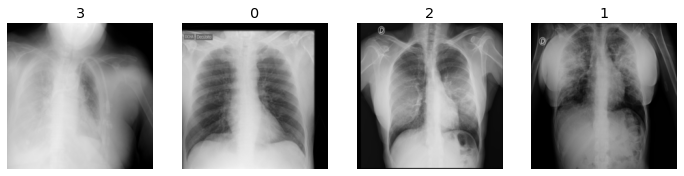

In [22]:
#dls = xray.dataloaders(targetsDF.values, num_workers=0)
dls.train.show_batch(max_n=4, nrows=1, unique=None) # uniqu=True allows to display only 1 image

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


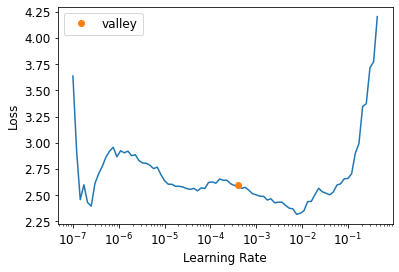

In [23]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
rate = learn.lr_find()

In [ ]:
# targetsDF_copy = targetsDF.copy()
noOfepochs = 2
num_of_swap = 5
acc = np.zeros((num_of_swap,1))
for k in range(num_of_swap):
    # dls = xray.dataloaders(targetsDF_copy.values, path=dataPath/imdsFolder, num_workers=0, verbose=None, bs=batchSize)
    cbs=[SaveModelCallback()]
    learn = cnn_learner(dls, resnet18, metrics=error_rate)
#     learn.fine_tune(noOfepochs, base_lr=rate.valley)
    learn.fine_tune(noOfepochs, base_lr=rate.valley, cbs=cbs)

    Y_pred = []
    for num in range(targetsDF.shape[0]):
        pred = learn.predict(targetsDF.values[num])        
        Y_pred.append(pred[0])
    
    Y_pred = pd.Series(Y_pred, index = targetsDF_copy.index)
    #ind = targetsDF_copy[((targetsDF.label == '1')|(targetsDF.label == '3'))&(Y_pred!=targetsDF.label)].index
    #targetsDF_copy.loc[ind, 'label'] = '2'
    #ind = targetsDF_copy[((targetsDF.label == '1')|(targetsDF.label == '3'))&(Y_pred==targetsDF.label)&(targetsDF_copy.label == '2')].index
    #targetsDF_copy.loc[ind, 'label'] = Y_pred.loc[ind]    
    acc[k] = accuracy(targetsDF.label.values, Y_pred)

epoch,train_loss,valid_loss,error_rate,time
0,1.668698,1.344451,0.473000,14:08


Better model found at epoch 0 with valid_loss value: 1.3444510698318481.


epoch,train_loss,valid_loss,error_rate,time
0,1.484328,1.208946,0.440000,17:01
1,1.276620,1.155248,0.417000,18:17


Better model found at epoch 0 with valid_loss value: 1.2089455127716064.
Better model found at epoch 1 with valid_loss value: 1.1552479267120361.


epoch,train_loss,valid_loss,error_rate,time


In [ ]:
def accuracy(y, y_p):
    return(y==y_p).sum()/y.shape[0]

In [ ]:
acc

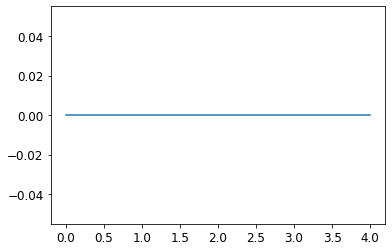

In [27]:
plt.plot(np.arange(acc.shape[0]),acc)
plt.show()

In [28]:
Y_pred

6222    1
3711    1
3047    1
3613    0
1575    0
       ..
4124    0
4889    1
3363    2
4788    1
2866    1
Length: 5000, dtype: object

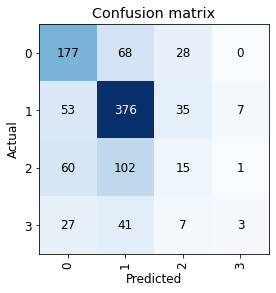

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(NoOfDispImds, nrows=2)

In [ ]:
learn.export()

References

[1] https://docs.fast.ai/tutorial.medical_imaging.html#Download-and-import-of-X-ray-DICOM-files